In [1]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import config

plt.style.use('seaborn')

/home/abian/Workspace/Anaconda/envs/ResearchStay/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Notas

Gradient of EBK based exclusively to the reconstruction...

In [25]:
from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss

from HySpecLab.unmixing import ContrastiveUnmixing
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torch import sigmoid
from torch.utils.data import Dataset, DataLoader

def train(model:nn.Module, n_endmembers:int, dataset:Dataset, n_batchs:int = 64, n_epochs:int = 100, lr=1e-3):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = UnmixingLoss()
    entropy_reg  = NormalizedEntropy(S=n_endmembers)    
    volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers).to(device)
    similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')


    dataloader = DataLoader(dataset, batch_size=int(len(dataset)/n_batchs), shuffle=True)

    epoch_iterator = tqdm(
            range(n_epochs),
            leave=True,
            unit="epoch",
            postfix={"tls": "%.4f" % -1},
        )

    entropy_weight = 1e-1
    simplex_weight = 1e-5
    similarity_weight = 1e-1

    # entropy_weight = 0
    # simplex_weight = 0
    # similarity_weight = 0

    scaler = torch.cuda.amp.GradScaler()

    for epoch in epoch_iterator:
        epoch_loss = 0.
        for i, (x) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            y = model(x)
            loss = criterion(y, x) + entropy_weight*entropy_reg(model.A) + simplex_weight*volume_reg(sigmoid(model.ebk)) + similarity_weight*similarity_reg(model.ebk)
            epoch_loss += loss.detach().item()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
        epoch_iterator.set_postfix(tls="%.4f" % (epoch_loss/(i+1)))

In [26]:
from torch.utils.data import Dataset
from torch import tensor
import scipy.io as sio
import numpy as np

class HSIDataset(Dataset):
    def __init__(self):
        super(HSIDataset, self).__init__()

    def preprocessing(self, X:np.ndarray):
        '''
            Preprocessing the dataset for removing high-frequency noise. 
            This preprocessing consists of three steps:
                1. Median filter in the spatial domain.
                2. Moving average filter in the spectral domain.
                3. Normalization of the data.

            Parameters
            ----------
                X : np.ndarray, shape (nRow, nCol, nBand)
                    HSI Cube.
        '''

        from skimage.filters import median
        from utils import moving_average

        max_value = X.max()

        X = median(X, footprint=np.ones((3,3,1)))
        # X = moving_average(X.reshape(-1, X.shape[-1]), 3, padding_size=2).reshape(X.shape[0], X.shape[1], -1)
        X = X / (max_value + 1e-3)
        return X

class JasperRidge(HSIDataset):
    def __init__(self, root_dir, transform=None):
        super(JasperRidge, self).__init__()
        data = sio.loadmat(os.path.join(root_dir, 'jasperRidge2_R198.mat'))
        y = sio.loadmat(os.path.join(root_dir, 'GroundTruth/end4.mat'))

        self.n_row, self.n_col = data['nRow'].item(), data['nCol'].item()

        self.X = data['Y'].T.reshape(self.n_row, self.n_col, -1) # (nRow, nCol, nBand)
        self.X = self.preprocessing(self.X).reshape(-1, self.X.shape[-1]) # (nRow*nCol, nBand)
        self.X = tensor(self.X, dtype=torch.float32)

        self.E = tensor(y['M'].T, dtype=torch.float32) # (nEndmember, nBand)
        self.A = tensor(y['A'].T, dtype=torch.float32) # (nRow*nCol, nEndmember)
        self.n_bands = self.X.shape[1]
        self.n_endmembers = self.E.shape[0]
        
        self.transform = transform

    def __len__(self):
        return self.n_row * self.n_col

    def __getitem__(self, idx):
        sample = self.X[idx]
        if self.transform:
            sample = self.transform(sample)

        return sample

    def endmembers(self):
        return self.E

    def abundance(self):
        return self.A.reshape(self.n_row, self.n_col, -1)

    def image(self):
        return self.X.reshape(self.n_row, self.n_col, -1)


In [27]:
dataset_name = 'JasperRidge'
dataset = JasperRidge(config.JasperRidge_PATH)

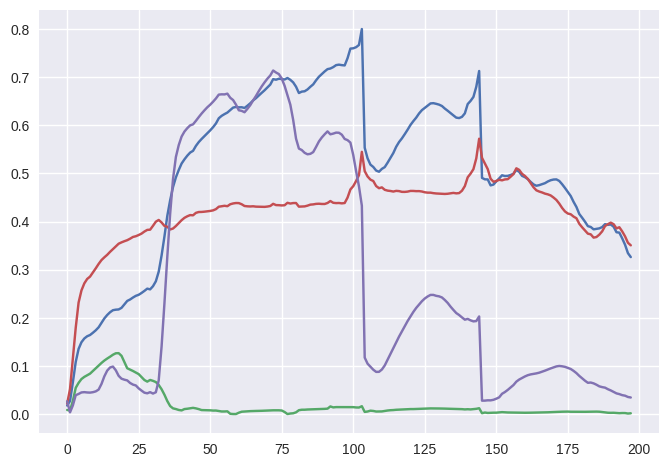

In [28]:
from HySpecLab.eea import VCA

n_endmembers = dataset.n_endmembers + 0
vca = VCA(n_endmembers=n_endmembers, snr_input=1, random_state=128)

E = vca.fit(dataset.X.numpy())
endmember_init = torch.from_numpy(vca.endmembers()).float()
# endmember_init = (endmember_init / endmember_init.max(dim=1, keepdim=True)[0]) * .8

logit_endmember_init = torch.log((endmember_init / (1-endmember_init) + 1e-12))
    
plt.plot(endmember_init.T)
plt.show()

In [14]:
# from pysptools import eea
# n_endmembers = dataset.n_endmembers + 0

# ee = eea.NFINDR()
# endmember = ee.extract(dataset.image().numpy(), n_endmembers)
# endmember_init = torch.from_numpy(endmember).float()

# # endmember_init = (endmember_init / endmember_init.max(dim=1, keepdim=True)[0]) * .8

# logit_endmember_init = torch.log((endmember_init / (1-endmember_init) + 1e-12))

# with plt.style.context(("seaborn-colorblind")):
#     plt.plot(endmember_init.T)
# plt.show()

In [15]:
n_bands = dataset.n_bands
model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init)
train(model, n_endmembers, dataset, n_batchs=80, n_epochs=25, lr=1e-3)

100%|██████████| 25/25 [00:18<00:00,  1.37epoch/s, tls=0.1278]


# Test

In [16]:
criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers)
similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')

In [17]:
_X = dataset.X

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(sigmoid(model.ebk)).cpu())

tensor(0.0528) tensor(0.5006) tensor(54.0309) tensor(0.3817)


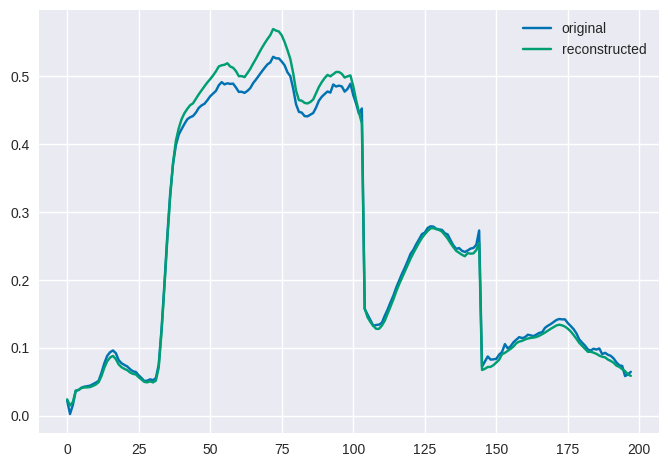

In [18]:
with plt.style.context(("seaborn-colorblind")):
    plt.plot(_X[1020].cpu(), label='original')
    plt.plot(reconstruc[1020].cpu().detach(), label='reconstructed')
    plt.legend()
plt.show()

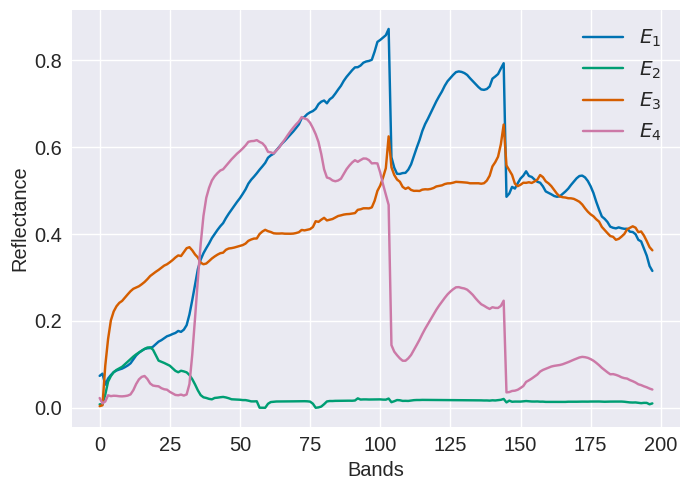

In [19]:
labels = list(map(lambda x: f'$E_{x}$', range(1, n_endmembers+1)))
ebk = sigmoid(model.ebk).detach().cpu()
with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(7, 5))
    plt.plot(ebk.T, label=labels)
    plt.ylabel('Reflectance', fontsize='x-large')
    plt.xlabel('Bands', fontsize='x-large')
    #legend background white
    plt.legend(fontsize='x-large', facecolor='white')
    plt.xticks(fontsize='x-large')
    plt.yticks(fontsize='x-large')
    plt.tight_layout()
    
plt.show()
# fig.savefig(os.path.join(config.IMG_PATH, dataset_name, 'CLHU_Endmembers.pdf'))

In [20]:
# ordering the endmembers
endmembers = dataset.endmembers().detach().cpu()
from HySpecLab.metrics import sad
sad_result = sad(ebk, endmembers)
print(sad_result)
idx = torch.argmin(sad_result, dim=1) # Index for reordering the ground truth
print(idx)

# reorder the endmembers
endmembers = endmembers[idx]

tensor([[0.4710, 1.1027, 0.0602, 0.2614],
        [1.1977, 0.0864, 1.1195, 0.9424],
        [0.6195, 0.9320, 0.2413, 0.0833],
        [0.0999, 1.1890, 0.5332, 0.6541]])
tensor([2, 1, 3, 0])


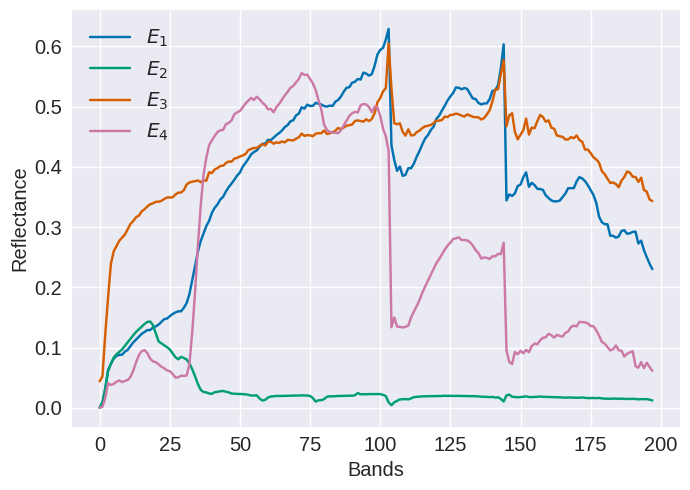

In [21]:
labels = list(map(lambda x: f'$E_{x}$', range(1, len(dataset.endmembers())+1)))
with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(7, 5))
    plt.plot(endmembers.T, label=labels)
    plt.ylabel('Reflectance', fontsize='x-large')
    plt.xlabel('Bands', fontsize='x-large')
    plt.legend(fontsize='x-large', facecolor='white')
    plt.xticks(fontsize='x-large')
    plt.yticks(fontsize='x-large')
    # plt.title('Ground Truth', fontsize='x-large')
    plt.tight_layout()
    plt.show()

# fig.savefig(os.path.join(config.IMG_PATH, dataset_name, 'Endmembers_GT.pdf'))

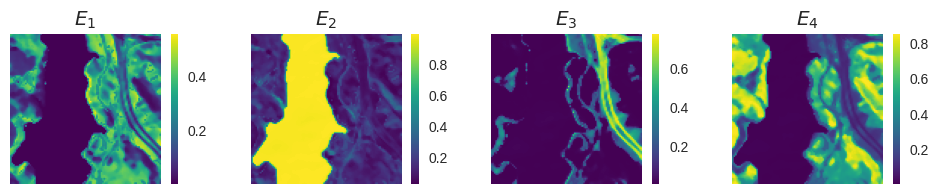

In [22]:
from torch.nn.functional import softmax
test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(100, 100, n_endmembers)
labels = list(map(lambda x: f'$E_{x}$', range(1, n_endmembers+1)))

# with plt.style.context(("seaborn-colorblind")):
fig = plt.figure(figsize=(12,7))
for i in range(n_endmembers):
    plt.subplot(4,5,i+1)
    # plt.imshow(test[:,:,i].T, vmin=0, vmax=softmax(model.A, dim=1).max(), cmap='viridis')
    plt.imshow(test[:,:,i].T, cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[i], fontsize='x-large')
    plt.colorbar()

plt.tight_layout()
plt.show()

# fig.savefig(os.path.join(config.IMG_PATH, dataset_name, 'CLHU_Abundance.png'), dpi=300, bbox_inches='tight')

In [ ]:
ebk = sigmoid(model.ebk).detach().cpu()
endmembers = dataset.endmembers()

from HySpecLab.metrics import sad
sad_result = sad(ebk, endmembers)
print(sad_result)
idx = torch.argmin(sad_result, dim=1) # Index for reordering the ground truth
print(idx)

from torch.nn.functional import mse_loss
def rmse(x: torch.Tensor, y: torch.Tensor):
    return torch.sqrt(mse_loss(x, y, reduction='none').mean(dim=1))

abundance = softmax(model.A.detach(), dim=1).cpu().reshape(100, 100, n_endmembers)
abundance = abundance.permute(2,0,1)
abundance_gt = dataset.abundance()[:,:,idx].permute(2,0,1) # Reorder the ground truth
endmember_gt = dataset.endmembers()[idx, :]

rmse_result = rmse(abundance.flatten(1), abundance_gt.flatten(1))
print(rmse_result)

In [ ]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

test = rmse(abundance[1,:,:], abundance_gt[1,:,:])
print(test)

In [ ]:
with plt.style.context(("seaborn-colorblind")):
    plt.subplot(1,2,1)
    plt.imshow(abundance[3,:,:].T, cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.subplot(1,2,2)
    plt.imshow(abundance_gt[3,:,:].T, cmap='viridis')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,2))
for i in range(dataset.n_endmembers):
    plt.subplot(1,dataset.n_endmembers,i+1)
    plt.imshow(abundance_gt[i,:,:].T, cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    
plt.show()
# fig.savefig(os.path.join(config.IMG_PATH, dataset_name, 'Abundance_GT.png'), dpi=300, bbox_inches='tight')

# An Informatic-Theoretical view on CLHU

$\begin{align}
I(\mathcal{X}; \mathcal{Z}) + \lambda R(\mathcal{Z}) \\
% \frac{\partial \mathcal{L}}{\partial \mathcal{H}} &= \frac{\partial \mathcal{L}}{\partial \mathcal{U}} \frac{\partial \mathcal{U}}{\partial \mathcal{H}} \\
\end{align}$

## Preparing the data

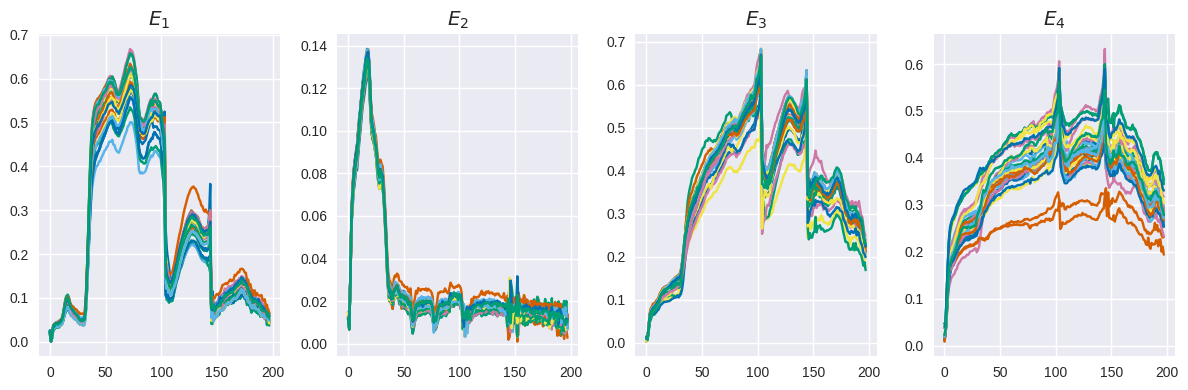

In [6]:
gt = dataset.abundance().permute(2,0,1)

#pick up the 32 first samples with the highest abundance per endmember
test_idx = torch.zeros(n_endmembers, 32, dtype=torch.long)
for i in range(n_endmembers):
    _, test_idx[i,:] = torch.topk(gt[i,:,:].flatten(), 32)

# plot it
with plt.style.context(("seaborn-colorblind")):
    fig = plt.figure(figsize=(12,4))
    for i in range(n_endmembers):
        plt.subplot(1, 4, i+1)
        plt.plot(dataset[test_idx[i]].T)
        plt.title(f'$E_{i+1}$', fontsize='x-large')

    plt.tight_layout()
    plt.show()

In [7]:
# sepparate train samples and test samples
train_idx = torch.ones_like(gt[0,:,:].flatten(), dtype=torch.bool)
train_idx[test_idx] = False
train_idx = torch.where(train_idx)[0]

# create a subset of the dataset
train_dataset = torch.utils.data.Subset(dataset, train_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx.flatten())

## Model

In [8]:
import torch 
import torch.nn as nn
from torch.nn import Parameter
from torch.nn.functional import softmax, normalize

from HySpecLab.unmixing.mixture import lmm
from HySpecLab.unmixing.utils import slide

from IPDL import MatrixEstimator

import torch 
import torch.nn as nn
from torch.nn import Parameter
from torch.nn.functional import softmax, normalize

class ContrastiveUnmixing(nn.Module):
    def __init__(self, n_bands, n_endmembers, encode_layers=[512, 128, 32], endmember_init=None) -> None:
        super(ContrastiveUnmixing, self).__init__()      
        encode_layers = [n_bands] + encode_layers
        
        # Encoder
        encoder = []
        for idx, test in enumerate(slide(encode_layers, 2)):
            encoder.append(self.__encode_layer(*test, dropout=True if idx < len(encode_layers)-2 else False))
        self.encoder = nn.Sequential(*encoder)

        # Endmember bank
        self.ebk = Parameter(torch.randn(n_endmembers, n_bands))
        if endmember_init is not None:
            self.ebk.data = endmember_init

        # Projection layer
        self.projection = nn.Sequential(
            nn.Linear(encode_layers[-1], n_bands, bias=False),
            MatrixEstimator(.1)
        )
        
        # Abundance matrix
        self.A = None
        self.A_matrix_estimator = MatrixEstimator(.1)
        self.matrix_estimator = MatrixEstimator(.1)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        r0 = self.projection( self.encoder(input) )

        self.A = self.A_matrix_estimator(self.__similarity(r0))
        out = lmm(softmax(self.A, dim=1), torch.sigmoid(self.ebk))
        return self.matrix_estimator(out)
        # return lmm(softmax(self.A, dim=1), torch.sigmoid(self.ebk))

    def __encode_layer(self, in_features, out_features, dropout=False):
        return nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            MatrixEstimator(.1),
            *[nn.ReLU(), nn.Dropout(0.5)] if dropout else [nn.Identity()]
        )

    def __similarity(self, X: torch.Tensor, temperature=1e-1) -> torch.Tensor:
        '''
            Cosine similarity between input and endmember bank.

            Parameters
            ----------
                x: torch.Tensor, shape=(batch_size, n_bands)
                    input tensor.
                
                temperature: float, default=1e-1
                    temperature parameter for contrastive learning.
                
        '''
        bs, n_bands = X.shape
        X = normalize(X, dim=1)

        normalize_ebk = normalize(self.ebk.detach(), dim=1).expand(bs, -1, -1)
        cos = torch.bmm(X.view(bs, 1, n_bands), torch.transpose(normalize_ebk, 1, 2)).squeeze()
        return (1 - torch.pow(cos, 2))/temperature


In [9]:
from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss

from tqdm import tqdm
from torch import sigmoid
from torch.utils.data import Dataset, DataLoader
from IPDL import AutoEncoderInformationPlane
from IPDL.optim import SilvermanOptimizer

def define_Ax(X: torch.Tensor, gamma:float=.8) -> torch.Tensor:
    from functools import reduce
    from IPDL.functional import matrix_estimator

    n = X.size(0)
    d = X.size(1) if len(X.shape) == 2 else reduce(lambda x, y: x*y, X.shape[1:])
    sigma = gamma * n ** (-1 / (4+d)) * np.sqrt(d) 

    _, Ax = matrix_estimator(X, sigma=sigma)
    return Ax

from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss

# from HySpecLab.unmixing import ContrastiveUnmixing
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torch import sigmoid
from torch.utils.data import Dataset, DataLoader

def train(model:nn.Module, n_endmembers:int, train_dataset:Dataset, test_dataset:Dataset, n_batchs:int = 64, n_epochs:int = 100, lr=1e-3):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = UnmixingLoss()
    entropy_reg  = NormalizedEntropy(S=n_endmembers)    
    volume_reg = SimplexVolumeLoss(train_dataset[:], n_endmembers).to(device)
    similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')


    dataloader = DataLoader(train_dataset, batch_size=int(len(train_dataset)/n_batchs), shuffle=True)

    epoch_iterator = tqdm(
            range(n_epochs),
            leave=True,
            unit="epoch",
            postfix={"tls": "%.4f" % -1},
        )

    entropy_weight = 1e-1
    simplex_weight = 1e-4
    similarity_weight = 1e-1

    scaler = torch.cuda.amp.GradScaler()

    #IPDL
    matrix_optimizer = SilvermanOptimizer(model, gamma=1e-2, normalize_dim=True)
    ip = AutoEncoderInformationPlane(model)
    Ax = define_Ax(test_dataset[:], gamma=1e-2)

    for epoch in epoch_iterator:
        epoch_loss = 0.
        model.train()
        for i, (x) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            y = model(x)
            loss = criterion(y, x) + entropy_weight*entropy_reg(model.A) + simplex_weight*volume_reg(sigmoid(model.ebk)) + similarity_weight*similarity_reg(model.ebk)
            epoch_loss += loss.detach().item()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        with torch.no_grad():
            model.eval()
            x = test_dataset[:].to(device)
            y = model(x)
            test_loss = criterion(y, x)
            
        epoch_iterator.set_postfix(tls="%.4f" % (epoch_loss/(i+1)), vls="%.4f" % test_loss.item())

        if epoch == 0: # Solo necesario una vez
            matrix_optimizer.step()

        _, _ = ip.computeMutualInformation(Ax.to(device))

    return ip


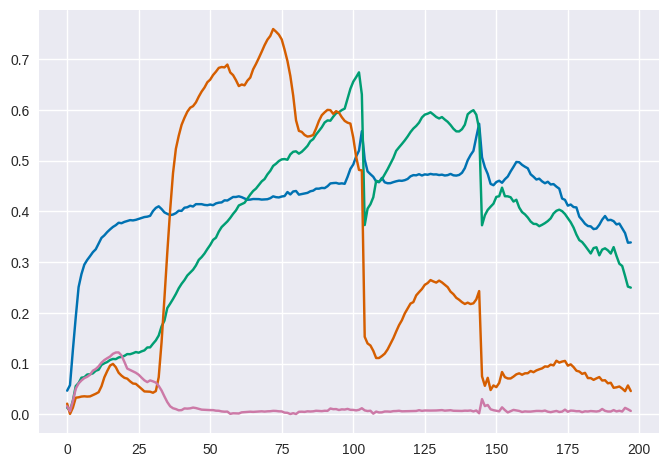

In [10]:
from pysptools import eea
n_endmembers = dataset.n_endmembers + 0

ee = eea.NFINDR()
endmember = ee.extract(dataset.image().numpy(), n_endmembers)
endmember_init = torch.from_numpy(endmember).float()
logit_endmember_init = torch.log((endmember_init / (1-endmember_init) + 1e-12))

with plt.style.context(("seaborn-colorblind")):
    plt.plot(endmember_init.T)
plt.show()

In [57]:
model = ContrastiveUnmixing(dataset.n_bands, n_endmembers, endmember_init=logit_endmember_init)
ip = train(model, n_endmembers, train_dataset, test_dataset, n_batchs=64, n_epochs=50, lr=1e-3)

100%|██████████| 50/50 [00:34<00:00,  1.44epoch/s, tls=0.1333, vls=0.0732]


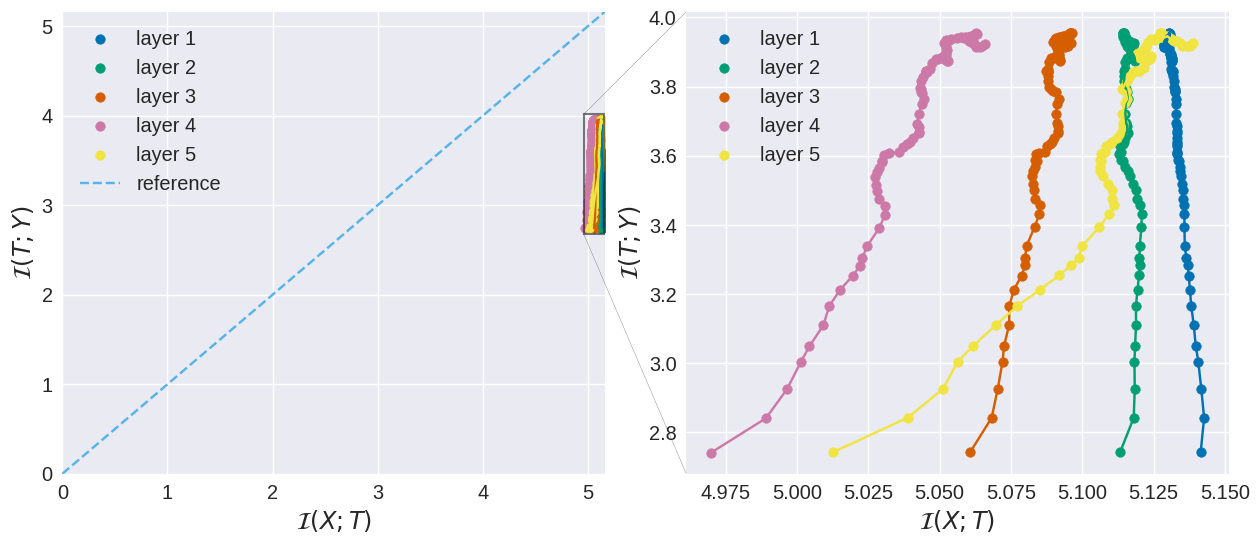

In [12]:
from matplotlib import pyplot as plt
from IPDL import MatrixBasedRenyisEntropy

Ax = define_Ax(test_dataset[:], gamma=1e-2)

with plt.style.context('seaborn-colorblind'):
    fig, ax = plt.subplots(figsize=(7, 6))
    reference = MatrixBasedRenyisEntropy.entropy(Ax).cpu()
    ax.set(xlim=(0, reference), ylim=(0, reference))
    axins = ax.inset_axes([1.15, 0., 1, 1])

    Ixt, Ity = ip.getMutualInformation(moving_average_n=10)

    for idx, current_Ixt in enumerate(Ixt):
        current_Ity = Ity[idx]
        ax.scatter(current_Ixt, current_Ity, label="layer {}".format(idx+1))
        ax.plot(current_Ixt, current_Ity)

        axins.scatter(current_Ixt, current_Ity, label="layer {}".format(idx+1))
        axins.plot(current_Ixt, current_Ity)

    ax.indicate_inset_zoom(axins, edgecolor="black", linewidth=1.5)
 
ax.set_xlabel("$\mathcal{I}(X;T)$", fontsize='xx-large')
ax.set_ylabel("$\mathcal{I}(T;Y)$", fontsize='xx-large')

axins.set_xlabel("$\mathcal{I}(X;T)$", fontsize='xx-large')
axins.set_ylabel("$\mathcal{I}(T;Y)$", fontsize='xx-large')
axins.legend(fontsize='x-large')

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed', label='reference')
ax.legend(fontsize='x-large')

#ticks bigger
ax.tick_params(axis='both', which='major', labelsize='x-large')
axins.tick_params(axis='both', which='major', labelsize='x-large')

plt.show()

# fig.savefig(os.path.join(config.IMG_PATH, dataset_name,'CLHU_ip_end{}.pdf'.format(n_endmembers)), bbox_inches='tight')

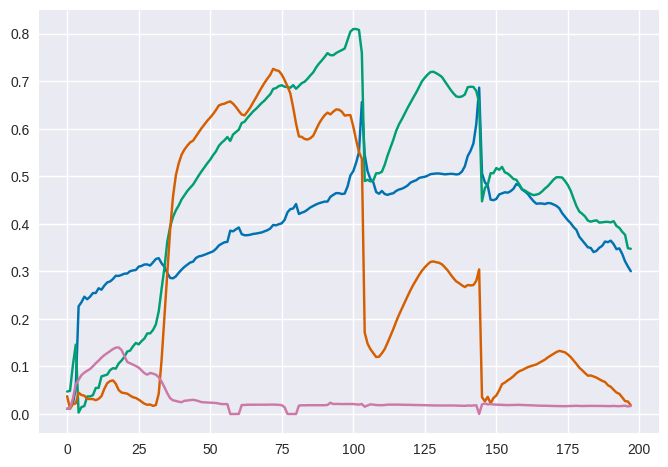

In [13]:
ebk = model.ebk.detach().cpu()
with plt.style.context(("seaborn")):
    with plt.style.context(("seaborn-colorblind")):
        plt.plot(torch.sigmoid(ebk).T)
plt.show()

In [14]:
z_m = model.encoder[-1][-2].x.cpu()
model = model.cpu()
# z_m = model.encoder[-1][-2]

def similarity_loss(z_m, model, temperature=.1):

    X = model.projection(z_m)
    bs, n_bands = X.shape
    X = normalize(X, dim=1)

    normalize_ebk = normalize(model.ebk.detach(), dim=1).expand(bs, -1, -1)
    cos = torch.bmm(X.view(bs, 1, n_bands), torch.transpose(normalize_ebk, 1, 2)).squeeze()
    return (1 - torch.pow(cos, 2))/temperature

Abund = similarity_loss(z_m, model).detach()
AAbund = define_Ax(Abund, gamma=.01)

In [15]:
from IPDL.InformationTheory import MatrixBasedRenyisEntropy as renyis
Hz = renyis.entropy(model.encoder[-1][-2].get_matrix())
Hz_p = renyis.entropy(model.projection[-1].get_matrix())
HA = renyis.entropy(AAbund)


Izy = renyis.mutualInformation(AAbund, model.encoder[-1][-2].get_matrix())
print(Izy)

tensor(6.1707)


In [16]:
reference

tensor(5.1634)

In [29]:
Ax = define_Ax(test_dataset[:], gamma=1e-2)
Az = model.encoder[-1][-2].get_matrix()

Ixz = renyis.mutualInformation(Ax, Az)
Ixz

Ixa = renyis.mutualInformation(Ax, AAbund)
print(Ixz, Ixa)

tensor(5.1009) tensor(5.1469)


In [31]:
Hx = renyis.entropy(Ax)
print(Hx)

Ha = renyis.entropy(AAbund)
print(Ha)

Hz = renyis.entropy(Az)
print(Hz)

tensor(5.1634)
tensor(6.7705)
tensor(6.1916)


In [36]:
MI = Hz_p - HA
print(Hz, HA, MI)

tensor(6.1916) tensor(6.7705) tensor(-0.7742)


In [37]:
MI = Hz_p - HA 
print(Hz_p, HA, MI)

tensor(5.9963) tensor(6.7705) tensor(-0.7742)


La información mutua puede ser negativa. La información mutua es una medida de la dependencia entre dos variables aleatorias, y se define como la reducción en la incertidumbre de una variable cuando se conoce el valor de la otra variable. Si las variables son independientes, la información mutua es cero, mientras que si son dependientes, la información mutua es positiva.

Sin embargo, en algunos casos, la información mutua puede ser negativa. Esto ocurre cuando el conocimiento del valor de una variable reduce la incertidumbre sobre otra variable de tal manera que la información obtenida es menor que la información que ya se tenía antes de conocer el valor de la primera variable. En otras palabras, en este caso, el conocimiento de una variable disminuye la incertidumbre de la otra variable, pero la información obtenida no es suficiente para compensar la información que se pierde al conocer la primera variable.

La información mutua negativa puede surgir en diversas situaciones, como por ejemplo en la cancelación de ruido en señales, en la detección de anomalías en datos, entre otros.

In [38]:
Aebk = define_Ax(model.ebk.detach().T, gamma=1e-2)
renyis.entropy(Aebk)

tensor(7.6256)

In [39]:
Aebk = define_Ax(torch.tensor(endmember).T, gamma=1e-2)
renyis.entropy(Aebk)

tensor(6.9850)

# Measure the MI between the latent space and EBK

In [40]:
ebk = model.ebk.detach().cpu()
z = model.projection[-1].x.cpu()

Aebk = define_Ax(ebk, gamma=1e-2)
Az = define_Ax(z, gamma=1e-2)

renyis.entropy(Aebk), renyis.entropy(Az)

(tensor(2.), tensor(5.9963))

In [41]:
ebk = model.ebk.detach().cpu()
z = model.projection[-1].x.cpu()

Aebk = define_Ax(ebk.T, gamma=1e-2)
Az = define_Ax(z.T, gamma=1e-2)

renyis.entropy(Aebk), renyis.entropy(Az), renyis.mutualInformation(Aebk, Az)


(tensor(7.6256), tensor(7.6294), tensor(7.6256))

In [42]:
n = 198
d_0, d_1 = 4, 128
sigma_0 = 5e-2 * n ** (-1 / (4+d_0)) * np.sqrt(d_0) 

sigma_1 = 5e-2 * n ** (-1 / (4+d_1)) * np.sqrt(d_1)

sigma_0, sigma_1

(0.05163175071313082, 0.5434705440799479)

In [43]:
z_mean = z.mean(axis=0)
ebk_mean = ebk.mean(axis=0)

from sklearn.metrics import mutual_info_score
from sklearn.metrics import normalized_mutual_info_score
def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

calc_MI(z_mean.numpy(), ebk_mean.numpy(), 100)

2.616274074961505

In [44]:
# compute entropy of z_mean and ebk_mean
def calc_H(x, bins):
    c_x = np.histogram2d(x, x, bins)[0]
    H = mutual_info_score(None, None, contingency=c_x)
    return H

calc_H(z_mean.numpy(), 100), calc_H(ebk_mean.numpy(), 100)

(3.9436397006570063, 3.8952453575553805)

In [45]:
mutual_info_score(z_mean, ebk_mean)

/home/abian/Workspace/Anaconda/envs/ResearchStay/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


5.288267030694538

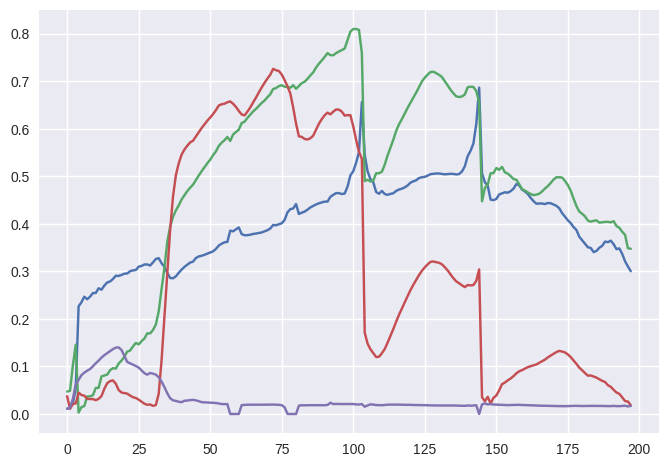

In [46]:
test = ebk.mean(axis=0)

plt.plot(torch.sigmoid(ebk.T))

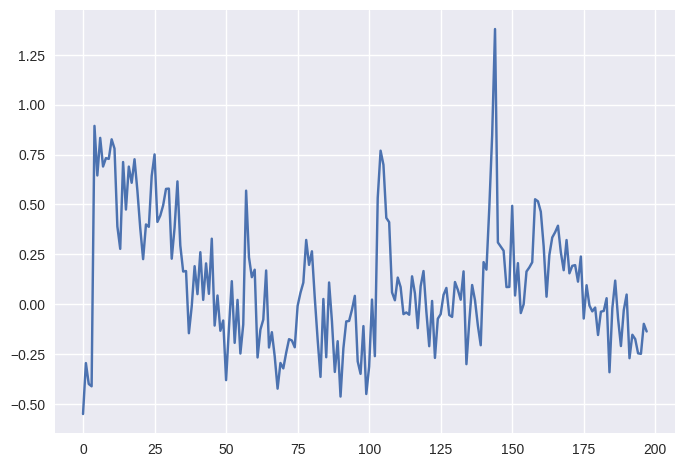

In [47]:
test = z.mean(axis=0)

plt.plot(test)


In [53]:
Ity

[array([2.74289885, 2.84246268, 2.9261374 , 3.00451159, 3.0502037 ,
        3.11158028, 3.16583524, 3.21209836, 3.25377946, 3.28347306,
        3.30551119, 3.33993697, 3.39350739, 3.43037715, 3.4565825 ,
        3.47555032, 3.49997649, 3.51774411, 3.54147968, 3.55482178,
        3.5667047 , 3.58349752, 3.58729038, 3.60475068, 3.60786328,
        3.61120391, 3.62721047, 3.6343154 , 3.63987107, 3.65211797,
        3.67023993, 3.66623683, 3.68556552, 3.69452648, 3.7220161 ,
        3.75109568, 3.76490965, 3.78350496, 3.78596849, 3.79378815,
        3.79834566, 3.81598625, 3.82932858, 3.84221683, 3.84520698,
        3.84356508, 3.84530573, 3.85211134, 3.87052345, 3.88196211,
        3.88173709, 3.88749714, 3.8800724 , 3.87506194, 3.8753737 ,
        3.88227963, 3.88915172, 3.89387493, 3.89540491, 3.89433823,
        3.90711408, 3.91075621, 3.91801877, 3.92758303, 3.93634901,
        3.93494697, 3.93912315, 3.94193854, 3.94442554, 3.94265676,
        3.94591908, 3.94406204, 3.94589176, 3.95

In [54]:
Ixt

[array([5.1414916 , 5.14269624, 5.1417027 , 5.14065375, 5.13977113,
        5.13903685, 5.13818436, 5.13773298, 5.13728752, 5.13688879,
        5.13644495, 5.13590569, 5.13580623, 5.13577867, 5.13557777,
        5.13532333, 5.13515487, 5.13483548, 5.13450785, 5.13436584,
        5.13415995, 5.13392363, 5.13363686, 5.13329477, 5.13315516,
        5.13316102, 5.13312225, 5.13329291, 5.13333101, 5.13322754,
        5.13321452, 5.13327208, 5.1331356 , 5.13298388, 5.13286362,
        5.13271317, 5.13273349, 5.13259048, 5.13246431, 5.1323843 ,
        5.13217168, 5.13205051, 5.13188081, 5.13172355, 5.13165207,
        5.13152957, 5.13136392, 5.13121638, 5.13122869, 5.13112712,
        5.1312057 , 5.13113713, 5.13128991, 5.13153586, 5.13144984,
        5.13140221, 5.131144  , 5.13095818, 5.13085847, 5.13063054,
        5.13041224, 5.13026371, 5.12991815, 5.12961397, 5.1296515 ,
        5.12977338, 5.12980671, 5.12997971, 5.12999992, 5.13020802,
        5.13032207, 5.13041449, 5.13064432, 5.13

In [55]:
ip.matrix_estimators

[MatrixEstimator(sigma=0.22, requires_optim=True),
 MatrixEstimator(sigma=0.11, requires_optim=True),
 MatrixEstimator(sigma=0.05, requires_optim=True),
 MatrixEstimator(sigma=0.14, requires_optim=True),
 MatrixEstimator(sigma=0.01, requires_optim=True),
 MatrixEstimator(sigma=0.14, requires_optim=True)]